### Import Statements

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import sys
import copy

In [2]:
%matplotlib inline

In [3]:
from funcs import matplotlib_imshow
from funcs import get_canvas

## **Perspective Transformation of an Image ([Docs](https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html))**

A 3x3 transformation matrix is required. Straight lines will remain straight even after the transformation. To find this transformation matrix, you need 4 points on the input image and their corresponding points on the output image. Among these 4 points, 3 of them should not be collinear. Then the transformation matrix can be found by the function `cv.getPerspectiveTransform()`. Then apply `cv.warpPerspective()` with this 3x3 transformation matrix.

<img src="./imgs/perspective_transformation.png" width=500 height=300>

> **The `cv.getPerspectiveTransform(points_on_input_img, points_on_output_img)` function**

<u>Function Parameters</u>
- points_on_input_img: 4 points on the input image (out of which 3 should not be colinear) to base the perspective shift on.
- points_on_output_img: 4 points on the output image corresponding to the points of the input image.

**Note:** The points arrays should be of `dtype=np.float32`

> **The `cv.warpPerspective(src, T, dsize)` function**

<u>Function Parameters</u>
- src: input imgae
- T: 3x3 transformation matrix
- dsize: output image size in the form of (width, height)

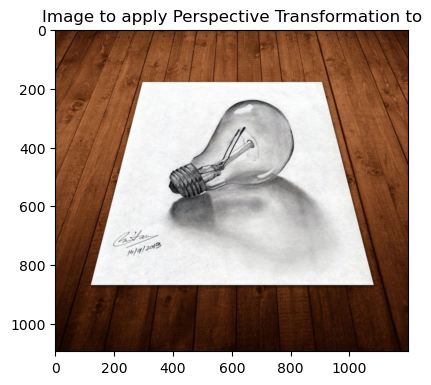

In [4]:
# example of perspective transformation
bulb_img = cv.imread("./imgs/bulb_3d.jpeg")
matplotlib_imshow("Image to apply Perspective Transformation to", bulb_img, 5)

In [5]:
bulb_img.shape

(1093, 1200, 3)

In [6]:
# eyeballing the corner points
points_on_the_source_img = np.float32([[300, 190], [910, 190], [130, 850], [1070, 850]])
to_be_points_on_the_transformed_img = np.float32(
    [[0, 0], [700, 0], [0, 800], [700, 800]]
)

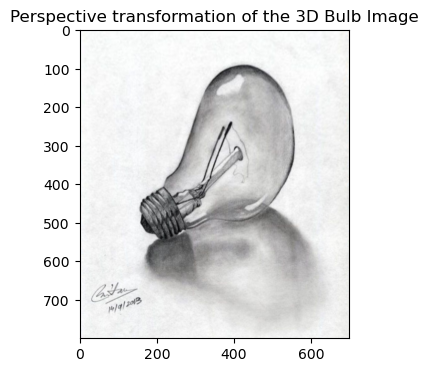

In [7]:
perspective_transformation_matrix = cv.getPerspectiveTransform(
    points_on_the_source_img, to_be_points_on_the_transformed_img
)
perspective_transformed_img = cv.warpPerspective(
    bulb_img, perspective_transformation_matrix, (700, 800)
)
matplotlib_imshow(
    "Perspective transformation of the 3D Bulb Image", perspective_transformed_img, 4
)

Yeah. Well, it works! But, not the best result we would hope for (or, we can achieve as a matter of fact).

### *Now, we will do this by utilizing the concepts learned in the Contour section.*

**Our goal** is to obtain a perspective transform of the "bulb_img" where we will determine the corner points of the image using some of the concepts learned in the Contour section (such as, finding contours, contour approximation etc.) instead of just eyeballing the corner points. Also, we would like to keep the aspect ratio of the page when we show the transformed output.

In [8]:
# first we convert the original image to grayscale
bulb_img_gray = cv.cvtColor(bulb_img, cv.COLOR_BGR2GRAY)
# threshold the grayscale image (we take lower threshold value a bit hight so that only the page is mostly highlighted)
_, bulb_img_gray_thresholded = cv.threshold(bulb_img_gray, 150, 255, cv.THRESH_BINARY)

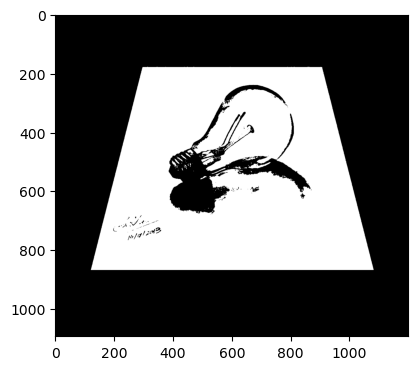

In [9]:
# the thresholded Image
matplotlib_imshow("", bulb_img_gray_thresholded, 5)

In [10]:
# finding the contours
cnt, hier = cv.findContours(
    bulb_img_gray_thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE
)

In [11]:
# len(cnt) = 1 i.e, only 1 contour was found (as expected)

In [12]:
cnt = cnt[0]
# see how much points is stored for identifying the detected contour: len(cnt)

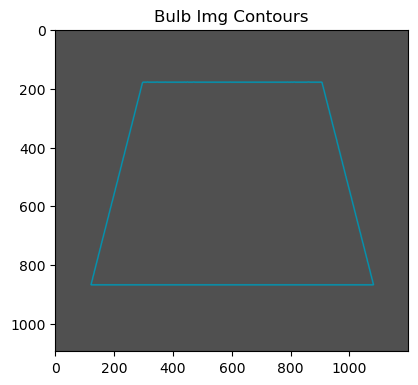

In [13]:
# drawing the found contour
canvas = get_canvas(bulb_img.shape, 80)
matplotlib_imshow(
    "Bulb Img Contours", cv.drawContours(canvas, cnt, -1, (180, 150), 3), 5
)

In [14]:
# we approximate the found contour to just 4 points, from the 2945 contour points, with approxPolyDP() function
perimeter = cv.arcLength(cnt, True)
approx = cv.approxPolyDP(cnt, 0.05 * perimeter, True)

In [15]:
# the approx array is of shape (4, 1, 2). So, we need the squeeze the array to turn it into a 4x2 array
approx.shape

(4, 1, 2)

In [16]:
# the points are in clockwise order i.e, top left, bottom left, bottom right, top right
corners = np.squeeze(approx, axis=1).astype(np.float32)
print(corners)

[[ 297.  181.]
 [ 122.  868.]
 [1082.  868.]
 [ 907.  180.]]


In [17]:
# to have the points in counterclock wise order i.e, top right, bottom right, bottom left, top left
# cv.convexHull(approx, clockwise=False, returnPoints=True)

In [18]:
# aspect ratio of the contour is given by, aspect ratio = w / h (of the bounding rectangle)
x, y, w, h = cv.boundingRect(corners)

In [19]:
# to be points on the transformed image
to_be_points = np.array([[0, 0], [0, h], [w, h], [w, 0]], dtype=np.float32)
print(to_be_points)

[[  0.   0.]
 [  0. 689.]
 [961. 689.]
 [961.   0.]]


In [20]:
# the perspective transformation matrix
pers_transform_mat = cv.getPerspectiveTransform(corners, to_be_points)

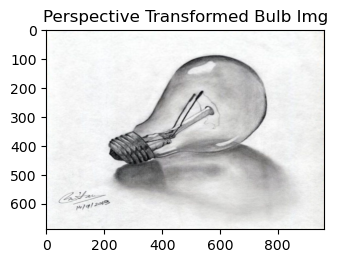

In [21]:
# the perspective transformed image
pers_transform_bulb_img = cv.warpPerspective(bulb_img, pers_transform_mat, (w, h))

matplotlib_imshow("Perspective Transformed Bulb Img", pers_transform_bulb_img, 5)